<h1> NYC Yellow Taxi Trip Data (2024) | <span style="font-size: 75%"> Cleaning and Aggregation </span> </h1>

<h2>Table of Contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#1--Importing-Data-and-Required-Libraries">1- Importing-Data and Required Libraries</a></li>
        <li><a href="#2--Exploring-the-Dataset">2- Exploring the Dataset</a></li>
        <li><a href="#3--Distribution-of-Categorical-Variables">3- Distribution of Categorical Variables</a></li>
        <li><a href="#4--Data-Cleaning">4- Data Cleaning</a></li>
        <li><a href="#5--Feature-Engineering">5- Feature Engineering</a></li>
        <li><a href="#6--Drop-Unnecessary-Columns">6- Drop Unnecessary Columns</a></li>
        <li><a href="#7--Handling-Null-Values">7- Handling Null Values</a></li>
        <li><a href="#8--Rearrange-Columns">8- Rearrange Columns</a></li>
        <li><a href="#9--Merge-with-Taxi-Zone-Lookup-Table">9- Merge with Taxi Zone Lookup Table</a></li>
        <li><a href="#10--Aggregating-the-Dataset">10- Aggregating the Dataset</a></li>
        <li><a href="#11--Apply-Cleaning-Steps-Across-All-the-Months">11- Apply Cleaning Steps Across All the Months</a></li>
    </ul>
</div>
<hr>

## __1- Importing Data and Required Libraries__

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set option to display all columns
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_parquet('nyc_yellow_taxi_dataset_2024.parquet', engine='pyarrow')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## __2- Exploring the Dataset__

We check the number of the records and columns.

In [5]:
print(f'This dataset has {df.shape[0]:,} ({df.shape[0]/1000000:.2f} million) rows and {df.shape[1]} columns')

This dataset has 41,169,720 (41.17 million) rows and 19 columns


We check the name of the columns.

In [7]:
# Let's print the column names
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

We check the data types of each column.

In [9]:
# Let's check the data types of the fields in the dataframe
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

* Two columns are datetime data types, which provide the __pickup__ and __dropoff__ date and time information.
* IDs and encoded fields include __vendors__, __locations__, __rate code__, and __payment type__.
* The remaining are numerical data types, which include trip distance in miles and a breakdown of the total fare.

Let's retrieve a statistical summary of the dataframe's numeric columns.

In [11]:
# Let's create a list of numerical columns
numerical_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 
                'Airport_fee', 'total_amount']

# Let's check the stats of these fields
df[numerical_cols].describe().style.format("{:,.2f}")

,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,total_amount
count,"41,169,720.00","41,169,720.00","41,169,720.00","41,169,720.00","41,169,720.00","41,169,720.00","41,169,720.00","37,078,488.00","37,078,488.00","41,169,720.00"
mean,4.98,19.27,1.39,0.48,3.31,0.56,0.96,2.23,0.15,27.83
std,419.23,76.72,1.82,0.13,4.09,2.24,0.26,0.87,0.50,78.05
min,0.00,"-2,261.20",-9.25,-0.50,-300.00,-140.63,-1.00,-2.50,-1.75,"-2,265.45"
25%,1.01,9.30,0.00,0.50,0.00,0.00,1.00,2.50,0.00,15.75
50%,1.76,13.50,1.00,0.50,2.60,0.00,1.00,2.50,0.00,21.00
75%,3.36,22.60,2.50,0.50,4.25,0.00,1.00,2.50,0.00,30.60
max,"398,608.62","335,544.44",65.99,41.30,999.99,"1,702.88",2.00,2.52,1.75,"335,550.94"


By checking the output, we notice a couple of problems:
* The maximum trip distance is about __399K miles__, which is about __642,000 km__, which does not make sense.
* The highest fare is about __$336K__, which is quite large for a taxi trip, I suppose.
* The maximum of tip_amount and tolls fare are quite extreme, both around __1000 USD__ and exceeding __1000 USD__ for the tolls.
* By checking the minimum values, they are all negative except for the __trip distance__, which is not valid.
* Many of the numeric columns are potentially positively skewed. This can be seen by comparing the median (50th percentile) and the mean — the latter is greater than the former for many of the columns.

We will deal with these later.

* This is a large dataset containing more than __40 million records__.
* Cleaning it all at once proves to be a memory-intensive and formidable task.
* We will explore and perform the cleaning steps on one month, and then generalize the steps performed to the remaining months.

Let's define a dataframe containing __January trips__.

In [13]:
# define a dataframe containing only the january trips
df_jan = df[df['tpep_pickup_datetime'].dt.month == 1].copy()

In [15]:
total_rows = df_jan.shape[0]
df_jan.shape

(2964637, 19)

The __January month__ contains less than __3 million records__, which is a more manageable subset of the original dataset.

## __3- Distribution of Categorical Variables__

We will check the distribution of categorical variables with a __pie chart function__. <br>
We will create the function `generate_pie_chart()`, which takes four inputs: _the field or column_, _titles for sub-charts_, _the plot's main title_, and _category labels_.

In [17]:
# create a pie chart function
def generate_pie_chart(field_cols, titles, title, custom_labels=[]):
    # Set up subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()  # Flatten to easily index


    for i in range(len(field_cols)):
        # Aggregate data
        data = field_cols[i].value_counts()

        # Calculate percentages
        percentages = 100 * data / data.sum()

        if custom_labels:
            if custom_labels[i]:
                data.index = data.index.map(custom_labels[i])
        
        if field_cols[i].dtype.name == 'bool':
            colors = data.index.map({True:'lightgreen', False:'skyblue'})
        else:
            colors = ['skyblue', 'lightgreen', 'orange', 'salmon', 'plum', 'gold', 'turquoise']
        
        # Create labels conditionally
        labels = [label if pct > 5 else '' for label, pct in zip(data.index, percentages)]

        # Plot
        axs[i].pie(
            data,
            labels=labels,
            autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'black'}
        )
        axs[i].set_title(titles[i])
    
    # Add main title
    plt.suptitle(title, fontsize=12, fontweight='bold')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for main title
    plt.tight_layout()
    plt.show()

We will use the above function `generate_pie_chart()` to check the distribution of __passenger_count__, __RatecodeID__, __store_and_fwd_flag__, and __payment_type__. <br>
But first, let's check the unique values in these columns.

In [19]:
# create a list of a column names
col_names = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']

for col in col_names:
    print(f'The unique values in {col} are:')
    print(str(df_jan[col].unique())+'\n')

The unique values in passenger_count are:
[ 1.  2.  0.  4.  3.  5.  6.  8.  7.  9. nan]

The unique values in RatecodeID are:
[ 1.  5.  2.  4. 99.  3.  6. nan]

The unique values in store_and_fwd_flag are:
['N' 'Y' None]

The unique values in payment_type are:
[2 1 4 3 0]



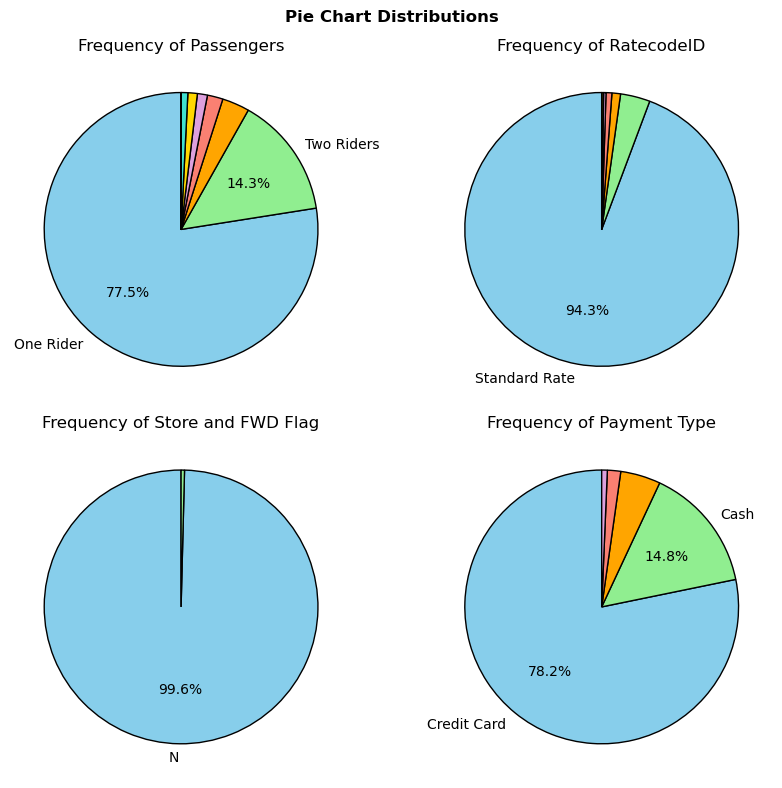

In [21]:
# Let's check the distribution for some of the categorical variables

# create a list of columns
fields_cols_list = [df_jan['passenger_count'], df_jan['RatecodeID'], df_jan['store_and_fwd_flag'], df_jan['payment_type']]

# create a list of titles for sub-charts
titles_list = ['Frequency of Passengers', 'Frequency of RatecodeID', 'Frequency of Store and FWD Flag','Frequency of Payment Type']

# create dictionary of labels, we will not include all the labels since categories below 5% are not shown in the pie chart
pass_map = {1 : 'One Rider', 2: 'Two Riders', 3:'Three Riders'} 
ratecodeid_map = {1: 'Standard Rate', 2: 'JFK', 3: 'Newark', 4:'Nassau or Westchester'}
payment_type_map = {0: 'Flex Fare Trip', 1: 'Credit Card', 2: 'Cash'}

# create a list of custom labels
labels = [pass_map, ratecodeid_map, None, payment_type_map]

title = "Pie Chart Distributions"

# call the function
generate_pie_chart(fields_cols_list, titles_list, title, labels)

__Interesting insights:__ <br>

* Around __77%__ of rides are __solo__, and __two-passenger__ rides account for just about __15%__. Rides with more than two passengers make up about __8%__ of all trips.
* __94%__ of the rides are charged using the standard rates.
* __99.6%__ of the trip records are transmitted in real time; as such, we can have high confidence in the timestamps.
* The store_and_fwd_flag distribution also indicates that New York has reliable and widespread cellular and wireless networks.
* __78%__ of all trips are paid by __credit card__. The next in line is __cash payments__, at a rate of about __15%__.

Let's now check the distribution of the vendors. 

In [23]:
print(f'The unique values in Vendor ID column is:')
print(df_jan['VendorID'].unique())

The unique values in Vendor ID column is:
[2 1 6]


In [25]:
# creating dictionary labels for vendors id
vendorid_dict = {1: 'Creative Mobile Technologies, LLC', 
                                 2: 'Curb Mobility, LLC',
                                 6: 'Myle Technologies Inc',
                                 7: 'Helix'}

counts = df_jan['VendorID'].value_counts()
counts.index = counts.index.map(vendorid_dict)
count = counts.to_frame()
count['percentage'] = count['count'] / count['count'].sum()
count['count'] = count['count'].apply(lambda x: f"{x:,}")
count['percentage'] = count['percentage'].apply(lambda x: f"{x:.2%}")
count

,count,percentage
VendorID,,
"Curb Mobility, LLC","2,234,645",75.38%
"Creative Mobile Technologies, LLC","729,732",24.61%
Myle Technologies Inc,260,0.01%


The trip records for the month of __January__ come from __three providers__.

Now, let's delete unneeded resources.

In [27]:
del fields_cols_list
del counts
del count

## __4- Data Cleaning__

### __A- Passenger Count Field__

In [29]:
# let's check the unique values in the passenger column
df_jan['passenger_count'].unique()

array([ 1.,  2.,  0.,  4.,  3.,  5.,  6.,  8.,  7.,  9., nan])

* The limit for passengers in taxis in New York is __4__ and does not exceed __5 passengers__.
* We observe numbers ranging from __9 to 0__, coupled with null values.
* We can drop records with an invalid number of passengers, but a better approach that saves valuable information is to label the passenger count for these trips as "Unknown."

In [31]:
# create the logic for trips with invalid number of passengers
invalid_passengers = (df_jan['passenger_count'] < 1) |(df_jan['passenger_count'] > 5) | (df_jan['passenger_count'].isna())

# Let's label this invalid counts as unknown and of course now we have to change the data type of the column to string
df_jan['passenger_count'] = df_jan['passenger_count'].astype(str)

# Replace them with "Unknown"
df_jan.loc[invalid_passengers, 'passenger_count'] = "Unknown"

In [33]:
# deleting unneeded resources
del invalid_passengers

### __B- Year of the trip__

* Let's check the unique years in the __(pickup datetime)__ columne to make sure all the trips belong to the year __2024__.

In [35]:
df_jan['tpep_pickup_datetime'].dt.year.unique()

array([2024, 2009, 2025])

Okay, let's keep the trips with __pickup timestamp__ belonging to year __2024__.

In [37]:
invalid_year = df_jan['tpep_pickup_datetime'].dt.year != 2024
df_jan = df_jan[~invalid_year]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,964,617 (2.96 million) rows and 19 columns


### __C- Dropoff Time is earlier than Pickup time__

* Let's check where the __dropoff timestamp__ is smaller than __pickup timestamp__.
* Taxis are not time-traveling, so the dropoff time must be later or bigger than the pickup time.
* Let's check the number of occurrences for such a mistake.

In [39]:
# Let's check for instances where the drop off date time is bigger than the pickup datetime
neg_duration = df_jan['tpep_pickup_datetime'] >= df_jan['tpep_dropoff_datetime']
df_jan['neg_duration'] = neg_duration
num_neg_duration = df_jan[df_jan['neg_duration'] == True].shape[0]
per_neg_duration = num_neg_duration/df_jan.shape[0]*100
print(f'This number of enteries with negative or zero trip duration is {num_neg_duration:,} rows and now they make about {per_neg_duration:.2f}%')

This number of enteries with negative or zero trip duration is 870 rows and now they make about 0.03%


* The extent of this error is not very common, making only about __0.03%__ of all the trips.
* Let's try to check where these __time-travelling__ records are coming from using our pie-generating function..

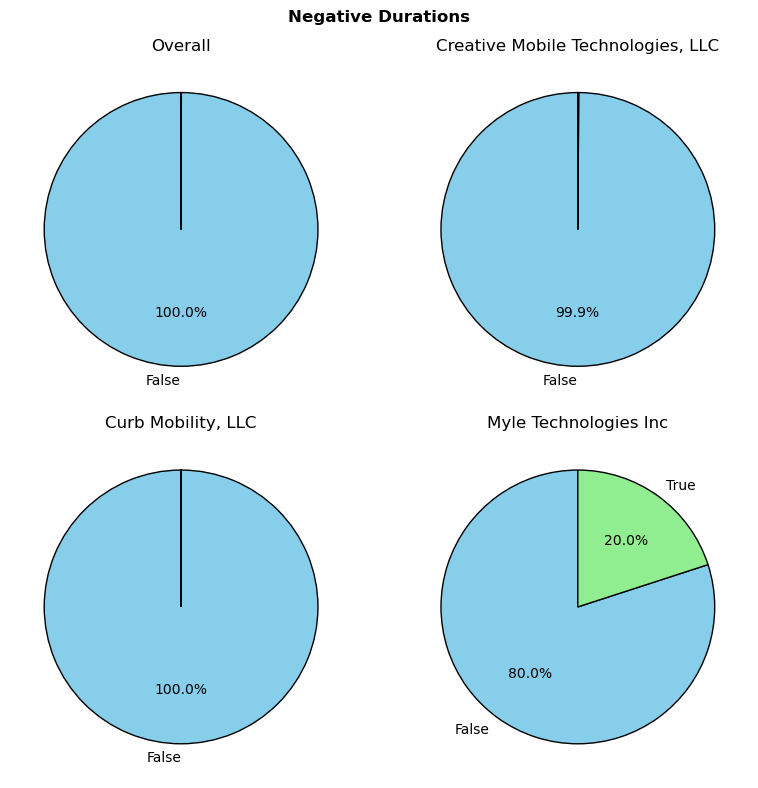

In [41]:
# Let's Check where negative trip durations occur
# Create a column that flags rows with any negative fee/fare component
fields_cols_list = [df_jan['neg_duration'], 
                    df_jan[df_jan['VendorID'] == 1]['neg_duration'], 
                    df_jan[df_jan['VendorID'] == 2]['neg_duration'],
                    df_jan[df_jan['VendorID'] == 6]['neg_duration']]

titles_list = ['Overall', vendorid_dict[1], vendorid_dict[2], vendorid_dict[6]]
 
title = "Negative Durations"

generate_pie_chart(fields_cols_list, titles_list, title)

* The occurrence of this error in the records provided by __Myle Technologies__ is about __20%__.
* The __Myle Technologies__ provide very small number of records for the Month of __January__.

In [43]:
# For some of the records, the trip duration would be negative or zero, we will drop these records
df_jan = df_jan[df_jan['neg_duration'] == False]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,963,747 (2.96 million) rows and 20 columns


In [45]:
# deleting unneeded resources and we will drop the neg_duration column
del neg_duration
del fields_cols_list
df_jan.drop('neg_duration', axis=1, inplace=True)

### __D- Checking Individual Fare Components__

#### __Total Amount__

* To the right of the __total_amount column__, we have __congestion surcharge and airport fee components__, and to the left of it, the remaining fee components.
* We would like to check how the __total_amount column__ is calculated.
* Let's check if the total amount is calculated using the following formula: _Total Amount_ = __SUM(All fare components)__

We will create a function in order to perform this operation in chunks to avoid overaloading the memeory.

In [47]:
def check_total_sum_col(df, fees_list):
    # this is a large dataset, let's perform our processing in chunks to avoid overloading the memory
    # Parameters
    chunk_size = 500000
    n_rows = df.shape[0]
    
    # Result holder
    total_amount_checks = []
    
    # Chunked row-wise processing
    for start in range(0, n_rows, chunk_size):
        end = min(start + chunk_size, n_rows)
        chunk = df_jan.iloc[start:end]
        
        # Fill NaNs, sum, round to 2 digits and then compare
        chunk_result = (chunk[fee_comp_cols].fillna(0).sum(axis=1).round(2) == chunk['total_amount'].round(2))
        
        # Store Boolean results
        total_amount_checks.extend(chunk_result.tolist())

    return total_amount_checks

In [49]:
# create a list of all fee components
fee_comp_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']

# Create new field that check if the total amount column is the sum of all fee_components
df_jan['check_total_sum'] = check_total_sum_col(df_jan, fee_comp_cols)

Now we check if the different vendors (record providers) calculate the total column similarly.

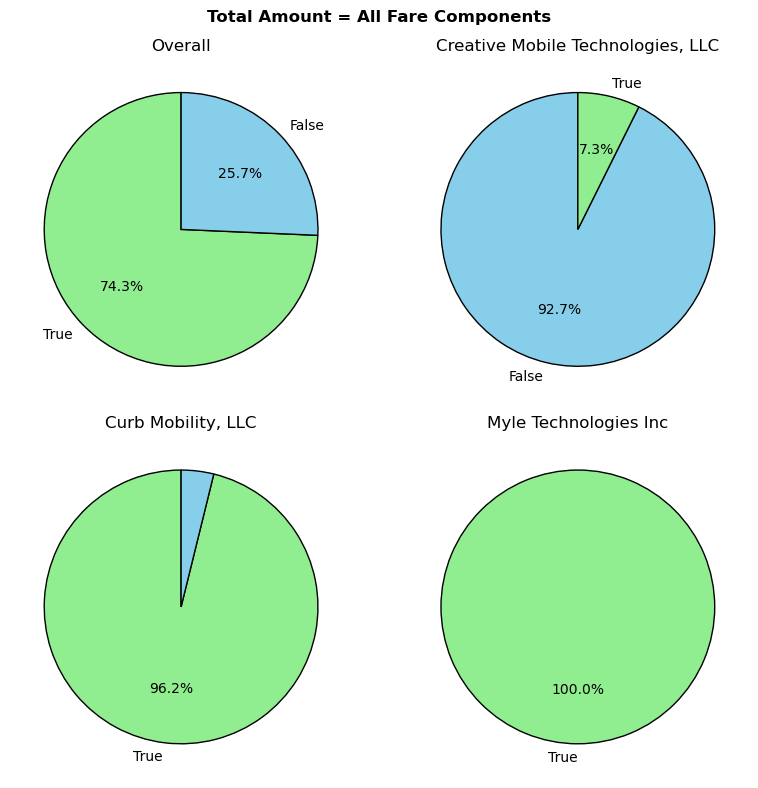

In [51]:
# list of columns to be passed to the pie function
fields_cols_list = [df_jan['check_total_sum'], 
                    df_jan[df_jan['VendorID'] == 1]['check_total_sum'], 
                    df_jan[df_jan['VendorID'] == 2]['check_total_sum'],
                    df_jan[df_jan['VendorID'] == 6]['check_total_sum']]

# list of titles
titles_list = ['Overall', vendorid_dict[1], vendorid_dict[2], vendorid_dict[6]]


# Plot main title
title = "Total Amount = All Fare Components"
generate_pie_chart(fields_cols_list, titles_list, title)

* The calculation of the total_amount column is not consistent. About __75%__ of the trips follow the formula tested.
* We will drop the total column and define it later as the sum of all fare components. 

In [53]:
df_jan.drop(['total_amount', 'check_total_sum'], axis=1, inplace=True)

In [55]:
# deleting unneeded resources 
del fields_cols_list

#### __Improvement Surcharge__

* The taxi fare include __$1.00 improvement surcharge__ for all trips charged following __standard rate codes__.
* Let's check the unique values for this column.

In [57]:
# it is a fixed one dollar for all trips
df_jan['improvement_surcharge'].unique()

array([ 1. , -1. ,  0. ,  0.3, -0.3])

* Well, the range of values seems acceptable except for the __negative__ _\\$1.00_ and _\\$0.30_.
* Let's correct these __negative__ values by making them __positive__.

In [59]:
# Let's turn negative numbers into positive numbers
df_jan['improvement_surcharge'] = df_jan['improvement_surcharge'].abs()

Trips with standard rate codes should have __improvement_surcharge__ equals to one. <br>
Now, let's remove trip records where this is not true.

In [61]:
# we assume standard trips to include Standard rate, JFK, Newark and Nassau or Westchester
# Let's define a list standard trips defined by the Rate Code IDs
standard_trips_rateCode = [1, 2, 3, 4]
invalid_standard_trips = (df_jan['improvement_surcharge'] != 1) & (df_jan['RatecodeID'].isin(standard_trips_rateCode))
df_jan = df_jan[~invalid_standard_trips]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,963,062 (2.96 million) rows and 18 columns


For non standard trips, we will leave them as they are.

In [63]:
# deleting unneeded resources
del invalid_standard_trips

#### __MTA Tax__

* The taxi fare include __50 cents__ _MTA State surcharge_ for all trips charged following standard rate codes.
* Let's check the unique values for this column.

In [65]:
# The MTA tax is 50 cents, but it is only for trips that ends in certain locations
# As such it is either paid or not paid, so only two values 0.5 or 0
df_jan['mta_tax'].unique()

array([ 0.5,  0. , -0.5,  3. ])

* Well the range of values seems acceptable except for the __negative__ _\\$0.5_.
* Let's correct these negative values by making them __positive__.

About __34K__ records will be modified.

In [67]:
# Let's correct these values
df_jan['mta_tax'] = df_jan['mta_tax'].abs()

Trips with standard rate codes should have __MTA tax__ equals to _50 cents_. <br>
Now, let's remove trip records where this is not true.

In [69]:
invalid_mta_tax = (df_jan['mta_tax'] != 0.5) & (df_jan['RatecodeID'].isin(standard_trips_rateCode))
num_invalid_mta_tax = df_jan[invalid_mta_tax].shape[0]
df_jan = df_jan[~invalid_mta_tax]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,951,793 (2.95 million) rows and 18 columns


For non standard rate code trips, we will not modify the __MTA Tax__.

In [71]:
# deleting unneeded resources
del invalid_mta_tax

#### __Congestion Surcharges__

In [73]:
# Let's check the unique values in the congestion surcharge column
print(f'The unique values in the congestion surcharge column is {df_jan['congestion_surcharge'].unique()}.')

The unique values in the congestion surcharge column is [ 2.5   0.   -2.5   0.75 -0.75   nan].


* The values are reasonable and are in accordance with the charges applied to Taxies, __\\$2.5__ dollar rush hour surcharge and __75 cents__ for all trips that begin, end or pass through __Manhattan south of 96th Street__. <br>
* We have negative Value of negative __\\$2.5__ and __75__ cents, we will correct these values and make them positive. <br>
* We have __null values__ in the congestion_surcharge column, we will handle missing values later.

In [75]:
# Let's correct these values
df_jan['congestion_surcharge'] = df_jan['congestion_surcharge'].abs()

Let's check the unique values again to make sure that the __negative__ __$2.5__ values have been removed.

In [77]:
print(f'The unique values in the congestion surcharge column is {df_jan['congestion_surcharge'].unique()}.')

The unique values in the congestion surcharge column is [2.5  0.   0.75  nan].


#### __Airport Fees__

In [79]:
df_jan['Airport_fee'].unique()

array([ 0.  ,  1.75, -1.75,   nan])

* The values are within reasonable range, but we have a negative __-1.75 dollar__. 
* The airport pickup fee is __\\$1.75__ and hence then __negative 1.75__ is most likely an error.
* We will transform the negative values to positive values.

In [81]:
# Let's correct these values
df_jan['Airport_fee'] = df_jan['Airport_fee'].abs()

# Let's check the unique values again to make sure no negative values are present.
df_jan['Airport_fee'].unique()

array([0.  , 1.75,  nan])

#### __Negative Fare Values__

* Let's check if any remaining negative values are present in fare components fields. 
* We will remove any taxi trips with negative fare values.

In [83]:
# create a list that contain all the fare fields
fee_comp_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 
                'Airport_fee']
# Let us check the number of occurrences of negative values
negative_fare = (df_jan[fee_comp_cols] < 0).any(axis=1)

# we will filter out rows with negative fare value
df_jan = df_jan[~negative_fare]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,914,756 (2.91 million) rows and 18 columns


In [85]:
# deleting unneeded resources
del negative_fare

#### __Tolls Amount__

* The toll rates in New york can range anywhere from __\\$3__ to __\\$12__. 
* We can assume that per trip, the number of tolls crossed is anywhere between __0 to 3 tolls__.
* Using the information above, we can assume that the maximum possible tolls charges per trip is __\\$36__. 
* Let's check the distribution of the toll charges.

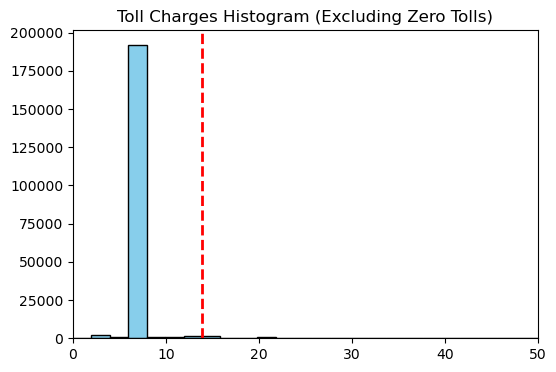

In [87]:
# Let's now check the distribution of the duration minutes
plt.figure(figsize=(6, 4))
plt.hist(df_jan[df_jan['tolls_amount'] > 0]['tolls_amount'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=df_jan['tolls_amount'].quantile(0.999), color='red', linestyle='--', linewidth=2)
plt.title('Toll Charges Histogram (Excluding Zero Tolls)')
plt.xlim(0, 50)
plt.show()

* The red dashed vertical line represents __0.999__ quantile which is at about __\\$14__.
* It can be seen that the majority of toll charges are conecentrated at roughly __\\$7.5__.
* The maximum possible toll fare for three tolls at a maximum rate of __\\$12/toll__ is __\\$36__.
* To add safe margin, we will discard any toll charges greater than _1.5 times_ __\\$36__ which is about __\\$54__.

In [89]:
# Let's remove any trips with a toll charges greater than 23 dollatr
df_jan = df_jan[df_jan['tolls_amount'] <= 54]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,914,717 (2.91 million) rows and 18 columns


#### __Tip Amount__

Tips are only recorded for credit card payments __(payment_type = 1).__ <br>
Let's check if tips are recorded for other mode of payments.

In [91]:
# Let's set these tips when the payment mode is not credit card to zero
df_jan.loc[df_jan['payment_type'] != 1, 'tip_amount'] = 0

In [93]:
# Let's check the maximum and minmum tip paid
df_jan['tip_amount'].min(), df_jan['tip_amount'].max()

(0.0, 428.0)

* The maximum paid tip is __\\$428__ which is quite large. 
* It is quite diffcult to determine if a tip of __\\$428__ is real or entry error. 
* Then, in order to check the tips paid by riders, let's check the distribution. 

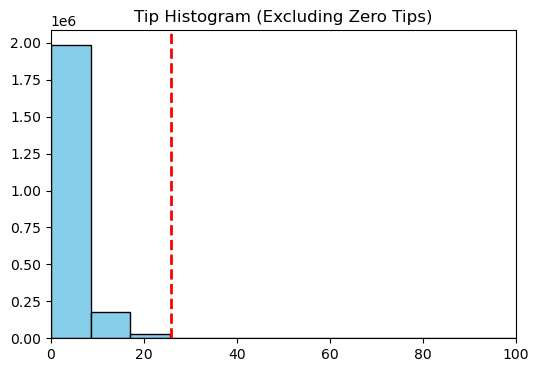

In [95]:
# Let's now check the distribution of the fare amount
plt.figure(figsize=(6, 4))
plt.hist(df_jan[df_jan['tip_amount'] > 0]['tip_amount'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=df_jan['tip_amount'].quantile(0.999), color='red', linestyle='--', linewidth=2)
plt.title('Tip Histogram (Excluding Zero Tips)')
plt.xlim(0,100)
plt.show()

* As before, the vertical red dashed line represents the __0.999__ quantile or the __99.9%__ percentile. 
* The __99.9__ percentile is roughly about __\\$25__. 
* Well, some customers might be just generous.
* Anyhow, we will choose to keep tips as long as they are not __120%__ greater than the fare.
* The choice is arbitrary in order not to remove legitimate, yet rare trips.
* Of course, for modelling purposes, the tip cap should probably be lower. 

In [97]:
# Let's filter out these records
df_jan = df_jan[df_jan['tip_amount'] <= 1.2*df_jan['fare_amount']]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,911,853 (2.91 million) rows and 18 columns


#### __Fare Amount__

* Standard fare has initial charge of __\\$3.00__.
* Let's remove trip records with fares lower than __\\$3.00__.

In [99]:
# Let's remove any trips with a fare less than three dollatr
df_jan = df_jan[df_jan['fare_amount'] >= 3]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,909,808 (2.91 million) rows and 18 columns


## __5- Feature Engineering__

* We well calculate the trip duration in minutes and the total cost of the taxi trip.
* We will extract the day, the hour and the month of the trip.
* Let's perform these operation in chuncks to avoid overloading the memory.
* Let's define a function to do that.

In [101]:
def create_new_features(df, fee_columns):
    # Parameters
    chunk_size = 500000
    n_rows = df.shape[0]
    
    # Result holders
    hour_col = []
    day_col = []
    duration_min_values = []
    total_amount_values = []
    
    # Chunked row-wise processing
    for start in range(0, n_rows, chunk_size):
        end = min(start + chunk_size, n_rows)
        chunk = df.iloc[start:end]
        
        # Perform the Calculations
        hour_results = chunk['tpep_pickup_datetime'].dt.hour
        day_results = chunk['tpep_pickup_datetime'].dt.day
        duration_results = (chunk['tpep_dropoff_datetime']-chunk['tpep_pickup_datetime']).dt.total_seconds()/60
        total_amount_results = chunk[fee_columns].sum(axis=1)
        
        # Store calculations results
        hour_col.extend(hour_results.tolist())
        day_col.extend(day_results.tolist())
        duration_min_values.extend(duration_results.tolist())
        total_amount_values.extend(total_amount_results.tolist())
        
    # create the new fields
    df['total_amount'] = total_amount_values
    df['hour'] = hour_col
    df['day'] = day_col
    df['duration_min'] = duration_min_values

Let's call the function to create the new features.

In [103]:
create_new_features(df_jan, fee_comp_cols)

Let's check the first few rows to observe the newly created columns.

In [105]:
df_jan.head(1)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,total_amount,hour,day,duration_min
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.0,0.0,1.0,2.5,0.0,22.7,0,1,19.8


### __Let's use the new Fields to clean the dataset further__

#### __Duration in Minutes__

* Let's remove invalid or unreasonable duration trips.
* __Taxi and FHV drivers__ are prohibited from transporting passengers for more than __10 hrs__ in any __24-hour period__. 
* The maximum cap for a one trip is __600 minutes__ and it is certainly much lesser than that. 
* Let's drop these records if they exist.

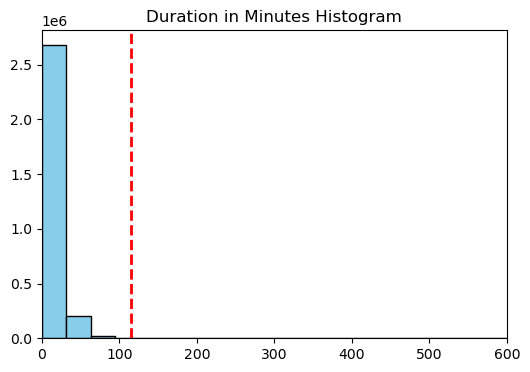

In [107]:
# Let's now check the distribution of the duration minutes
plt.figure(figsize=(6, 4))
plt.hist(df_jan['duration_min'], bins=300, color='skyblue', edgecolor='black')
plt.axvline(x=df_jan['duration_min'].quantile(0.999), color='red', linestyle='--', linewidth=2)
plt.title('Duration in Minutes Histogram')
plt.xlim(0, 600)
plt.show()

* The duration in minutes is heavily positively skewed. The vertical red dashed line represents the __0.999 quantile__ of the duration in minutes, which is roughly about __115 minutes__.
* To add a safe margin, let us drop trips with duration greater than __3 hrs__ (equivalently, __180 minutes__).

In [109]:
# Let's filter out these records 
df_jan = df_jan[df_jan['duration_min'] <= 180]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,907,852 (2.91 million) rows and 22 columns


#### __Trip Distance__

We will start with removing records with __zero mile distance__.

In [111]:
# Let's drop these records
df_jan = df_jan[df_jan['trip_distance'] > 0]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,853,412 (2.85 million) rows and 22 columns


* The speed limit in new york city is __25 miles/hr__ unless otherwise specified. 
* Taking this with the __10 hrs__ diriving daily limit, let's check distributions for trips distances less than __250 miles__ <br>
* It is quite possible some taxi drivers violate their speed limit, but it is cap for one trip

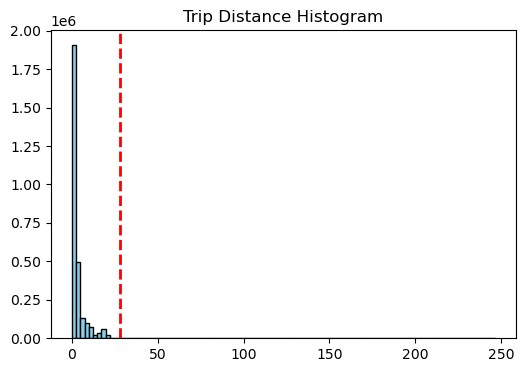

In [113]:
# Let's now check the distribution of the trip distances in miles
plt.figure(figsize=(6, 4))
plt.hist(df_jan[df_jan['trip_distance'] < 250]['trip_distance'], bins=100, color='skyblue', edgecolor='black')
plt.axvline(x=df_jan['trip_distance'].quantile(0.999), color='red', linestyle='--', linewidth=2)
plt.title('Trip Distance Histogram')
plt.show()

* Even the __0.999 quantile__ hovers around __25 miles__.
* Okay, will use the __3 hrs__ as the maximum for one trip along with __25 miles/hr__ speed.
* Thus, we will filter out rows with trip distances greater than __75 miles__.

In [115]:
# Let's filter out these records 
df_jan = df_jan[df_jan['trip_distance'] <= 75]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,853,346 (2.85 million) rows and 22 columns


#### __Maximum Fare Amount__

Now, knowing what we know about trip distances and trip duration, we can estimate the maximum fare amount.<br>
We discarded trips in which duration is greater than __180 minutes__ or __75 miles__. <br>
The standard fare is calculated as such,<br>
- __$3.00 initial charge__. 
- Plus __70 cents__ per __1/5 mile__ when traveling above __12mph__ or per __60 seconds__ in slow traffic or when the vehicle is stopped. <br>
Let's use these info to calculate fare based on maximum distance and based on maximum duration and then take the average between the two. <br>

In [117]:
# maximum fare based on maximum duration
max_fare_duration = 3 + 180*0.7
max_fare_distance = 3 + 75*0.7*5
average_fare = (max_fare_duration + max_fare_distance)/2
max_fare_duration, max_fare_distance, average_fare

(129.0, 265.5, 197.25)

The __average maximum fare__ is about __197.25__.<br>
Let's check the distribution of the fare amount.

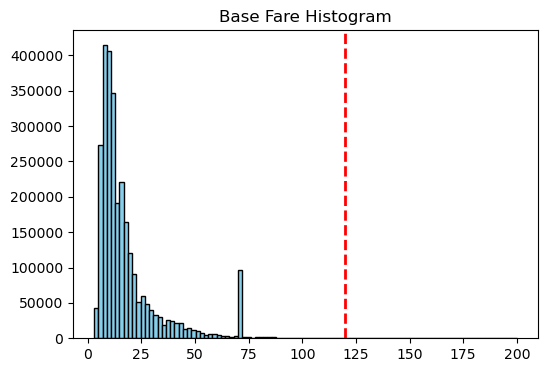

In [119]:
# Let's now check the distribution of the fare amount
plt.figure(figsize=(6, 4))
plt.hist(df_jan[df_jan['fare_amount'] <=200]['fare_amount'], bins=100, color='skyblue', edgecolor='black')
plt.axvline(x=df_jan['fare_amount'].quantile(0.999), color='red', linestyle='--', linewidth=2)
plt.title('Base Fare Histogram')
plt.show()

* The distribution of the fare amount is right skewed distribution, similar to trip distance and trip duration.
* This makes sense since the fare value is calculated based on trip duration and distances, so it is reasonable that they exhibit similar ditributions.
* The __0.999 quantile__ is about __\\$120__.
* Let's drop trips below __\\$200__.

In [121]:
# Let's filter out these records 
df_jan = df_jan[df_jan['fare_amount'] <= 200]
print(f'Now the dataset has {df_jan.shape[0]:,} ({df_jan.shape[0]/1000000:.2f} million) rows and {df_jan.shape[1]} columns')

Now the dataset has 2,852,777 (2.85 million) rows and 22 columns


## __6- Drop Unnecessary Columns__

In [123]:
# Let's define a list of unnecessary columns
irrelevant_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag']
df_jan = df_jan.drop(irrelevant_cols, axis=1)

## __7- Handling Null Values__

In [125]:
df_jan.isnull().sum()[df_jan.isnull().sum() > 0]

congestion_surcharge    113848
Airport_fee             113848
dtype: int64

In [127]:
# not all trips will have congestion or airport charges, so let's fill these null values with zeros
df_jan[['congestion_surcharge', 'Airport_fee']] = df_jan[['congestion_surcharge', 'Airport_fee']].fillna(0)

## __8- Rearrange Columns__

In [129]:
# create a list of ordere column names
cols = [ 'day', 'hour', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'duration_min', 'trip_distance', 'passenger_count', 
        'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
        'congestion_surcharge', 'Airport_fee', 'total_amount']
df_jan = df_jan[cols]

## __9- Merge with Taxi Zone Lookup Table__

In [131]:
# create the path for the taxi zone lookup table
path = r"D:\0_desktop_temp\data_analysisPro\yellow_taxi_dataset\taxi_zone_lookup.csv"

# load a dataset
df_zones = pd.read_csv(path)
df_zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


We will merge the trip dataframe with the taxi zone lookup dataframe twice to account for both Pickup and dropoff locations.

In [133]:
# Merge DataFrames
df_jan = pd.merge(df_jan, df_zones.drop(['service_zone', 'Zone'], axis=1), left_on='PULocationID', right_on='LocationID', how='left')
df_jan.rename(columns={'Borough': 'PU_Borough'}, inplace=True)

df_jan = pd.merge(df_jan, df_zones.drop(['service_zone', 'Zone'], axis=1), left_on='DOLocationID', right_on='LocationID', how='left')
df_jan.rename(columns={'Borough': 'DO_Borough'}, inplace=True)

In [135]:
# Let's check if we have missing values
df_jan.isna().sum()[df_jan.isna().sum() > 0]

PU_Borough     613
DO_Borough    8378
dtype: int64

In [137]:
# Let's assign the null Boroughs the Unknown label
df_jan['PU_Borough'] = df_jan['PU_Borough'].fillna('Unknown')
df_jan['DO_Borough'] = df_jan['DO_Borough'].fillna('Unknown')

Let's rearrange columns and drop redundant columns.

In [139]:
# Let's rearrange and drop unneeded columns
keep_cols = ['day', 'hour', 'duration_min', 'trip_distance', 'passenger_count',  'PU_Borough', 'PULocationID', 'DO_Borough', 'DOLocationID', 
            'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 
            'Airport_fee', 'total_amount']

df_jan = df_jan[keep_cols]

In [141]:
df_jan.head()

,day,hour,duration_min,trip_distance,passenger_count,PU_Borough,PULocationID,DO_Borough,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,total_amount
0,1,0,19.800000,1.72,1.0,Manhattan,186,Manhattan,79,2,17.7,1.0,0.5,0.00,0.0,1.0,2.5,0.0,22.70
1,1,0,6.600000,1.80,1.0,Manhattan,140,Manhattan,236,1,10.0,3.5,0.5,3.75,0.0,1.0,2.5,0.0,21.25
2,1,0,17.916667,4.70,1.0,Manhattan,236,Manhattan,79,1,23.3,3.5,0.5,3.00,0.0,1.0,2.5,0.0,33.80
3,1,0,8.300000,1.40,1.0,Manhattan,79,Manhattan,211,1,10.0,3.5,0.5,2.00,0.0,1.0,2.5,0.0,19.50
4,1,0,6.100000,0.80,1.0,Manhattan,211,Manhattan,148,1,7.9,3.5,0.5,3.20,0.0,1.0,2.5,0.0,18.60


## __10- Aggregating the Dataset__

In [143]:
# Group by multiple columns
categorical_cols = ['day', 'hour','passenger_count', 'PU_Borough', 'DO_Borough', 'payment_type']
df_grouped = df_jan.groupby(categorical_cols).agg(
    trip_count=('trip_distance', 'size'),
    trip_distance_sum=('trip_distance', 'sum'),
    duration_sum=('duration_min', 'sum'),
    fare_amount_sum=('fare_amount', 'sum'),
    extra_sum=('extra', 'sum'),
    mta_tax_sum=('mta_tax', 'sum'),
    tip_amount_sum=('tip_amount', 'sum'),
    tolls_amount_sum=('tolls_amount', 'sum'),
    improvement_surcharge_sum=('improvement_surcharge', 'sum'),
    congestion_surcharge_sum=('congestion_surcharge', 'sum'),
    airport_fee_sum=('Airport_fee', 'sum'),
    total_amount_sum=('total_amount', 'sum')
).reset_index()

In [145]:
df_grouped.head()

,day,hour,passenger_count,PU_Borough,DO_Borough,payment_type,trip_count,trip_distance_sum,duration_sum,fare_amount_sum,extra_sum,mta_tax_sum,tip_amount_sum,tolls_amount_sum,improvement_surcharge_sum,congestion_surcharge_sum,airport_fee_sum,total_amount_sum
0,1,0,1.0,Bronx,Bronx,2,2,1.60,9.216667,13.0,2.0,1.0,0.00,0.00,2.0,0.0,0.00,18.00
1,1,0,1.0,Bronx,Manhattan,2,1,7.50,18.666667,32.4,1.0,0.5,0.00,0.00,1.0,0.0,0.00,34.90
2,1,0,1.0,Brooklyn,Brooklyn,1,6,10.28,42.750000,60.7,6.0,3.0,11.65,0.00,6.0,0.0,0.00,87.35
3,1,0,1.0,Brooklyn,Brooklyn,2,4,5.89,38.050000,70.6,3.0,1.5,0.00,0.00,4.0,0.0,1.75,80.85
4,1,0,1.0,Brooklyn,Manhattan,1,10,53.13,263.683333,303.0,12.5,5.0,67.20,13.88,10.0,25.0,0.00,436.58


In [147]:
# Let's create a date column
date_col = pd.to_datetime({
    'year': 2024,
    'month': 1,
    'day': df_grouped['day']
})

# Insert it as the first column
df_grouped.insert(0, 'date', date_col)
df_grouped.drop('day', axis=1, inplace=True)

In [149]:
df_grouped['hour'] = df_grouped['hour'].apply(lambda x: f"{int(x):02d}:{0:02d}")

## __11- Apply Cleaning Steps Across All the Months__

Let's a create a function to do that.

In [151]:
def yellow_taxi_cleaning(df_taxi_trips, df_zones, fee_columns, keep_cols, agg_columns):
    
    df_agg_bor = pd.DataFrame()
    df_agg_zone = pd.DataFrame()
    
    agg_num_rows = 0
    
    for month_num in range(1, 13):
        df_month = df_taxi_trips[df_taxi_trips['tpep_pickup_datetime'].dt.month == month_num].copy()
        
        invalid_passengers = (df_month['passenger_count'] < 1) |(df_month['passenger_count'] > 5) | (df_month['passenger_count'].isna())
        df_month['passenger_count'] = df_month['passenger_count'].astype(str)
        df_month.loc[invalid_passengers, 'passenger_count'] = "Unknown"
        
        df_month = df_month[df_month['tpep_pickup_datetime'].dt.year == 2024]
        
        neg_duration = df_month['tpep_pickup_datetime'] >= df_month['tpep_dropoff_datetime']
        df_month = df_month[~neg_duration]

        df_month['improvement_surcharge'] = df_month['improvement_surcharge'].abs()
        standard_trips_rateCode = [1, 2, 3, 4]
        invalid_standard_trips = (df_month['improvement_surcharge'] != 1) & (df_month['RatecodeID'].isin(standard_trips_rateCode))
        df_month = df_month[~invalid_standard_trips]

        df_month['mta_tax'] = df_month['mta_tax'].abs()
        invalid_mta_tax = (df_month['mta_tax'] != 0.5) & (df_month['RatecodeID'].isin(standard_trips_rateCode))
        df_month = df_month[~invalid_mta_tax]

        df_month['congestion_surcharge'] = df_month['congestion_surcharge'].abs()
        
        df_month['Airport_fee'] = df_month['Airport_fee'].abs()
        
        negative_fare = (df_month[fee_columns] < 0).any(axis=1)
        df_month = df_month[~negative_fare]

        df_month = df_month[df_month['tolls_amount'] <= 54]

        df_month.loc[df_month['payment_type'] != 1, 'tip_amount'] = 0
        df_month = df_month[df_month['tip_amount'] <= 1.2*df_month['fare_amount']]
        
        df_month.drop(['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'total_amount'], axis=1, inplace=True)
        
        create_new_features(df_month, fee_columns)

        df_month = df_month[df_month['duration_min'] <= 180]

        df_month = df_month[(df_month['trip_distance'] > 0) & (df_month['trip_distance'] <= 75)]

        df_month = df_month[(df_month['fare_amount'] >= 3) & (df_month['fare_amount'] <= 200)]

        df_month[['congestion_surcharge', 'Airport_fee']] = df_month[['congestion_surcharge', 'Airport_fee']].fillna(0)

        df_month = pd.merge(df_month, df_zones.drop(['service_zone', 'Zone'], axis=1), left_on='PULocationID', right_on='LocationID', how='left')
        df_month.rename(columns={'Borough': 'PU_Borough'}, inplace=True)

        df_month = pd.merge(df_month, df_zones.drop(['service_zone', 'Zone'], axis=1), left_on='DOLocationID', right_on='LocationID', how='left')
        df_month.rename(columns={'Borough': 'DO_Borough'}, inplace=True)

        df_month['PU_Borough'] = df_month['PU_Borough'].fillna('Unknown')
        df_month['DO_Borough'] = df_month['DO_Borough'].fillna('Unknown')

        df_month = df_month[keep_cols]

        print(f"Number of trips before aggregation {df_month.shape[0]:,}")

        df_month_bor = df_month.groupby(categorical_cols).agg(
            trip_count=('trip_distance', 'size'),
            trip_distance_sum=('trip_distance', 'sum'),
            duration_sum=('duration_min', 'sum'),
            fare_amount_sum=('fare_amount', 'sum'),
            extra_sum=('extra', 'sum'),
            mta_tax_sum=('mta_tax', 'sum'),
            tip_amount_sum=('tip_amount', 'sum'),
            tolls_amount_sum=('tolls_amount', 'sum'),
            improvement_surcharge_sum=('improvement_surcharge', 'sum'),
            congestion_surcharge_sum=('congestion_surcharge', 'sum'),
            airport_fee_sum=('Airport_fee', 'sum'),
            total_amount_sum=('total_amount', 'sum')
        ).reset_index()

        date_col = pd.to_datetime({
            'year': 2024,
            'month': month_num,
            'day': df_month_bor['day']
        })

        df_month_bor.insert(0, 'date', date_col)
        df_month_bor.drop('day', axis=1, inplace=True)

        df_month_bor['hour'] = df_month_bor['hour'].apply(lambda x: f"{int(x):02d}:{0:02d}")

        df_month_zone = df_month.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='trip_count')

        df_month_zone = pd.merge(df_month_zone, df_zones.drop(['service_zone'], axis=1), left_on='PULocationID', right_on='LocationID', how='left')
        df_month_zone.rename(columns={'Borough': 'PU_Borough', 'Zone': 'PU_Zone'}, inplace=True)

        df_month_zone = pd.merge(df_month_zone, df_zones.drop(['service_zone'], axis=1), left_on='DOLocationID', right_on='LocationID', how='left')
        df_month_zone.rename(columns={'Borough': 'DO_Borough','Zone': 'DO_Zone'}, inplace=True)

        df_month_zone = df_month_zone[['PU_Borough', 'PU_Zone', 'DO_Borough', 'DO_Zone', 'trip_count']]
        df_month_zone.insert(0, 'month', month_num)

        print(f"After aggregation, the aggregated number of rows of the data frame of the month {month_num} is {df_month_bor.shape[0]:,}")
        print(f"The aggregation summarizes a total of {df_month_bor['trip_count'].sum():,} trips")
        print("--------------------------------------------------------------------------------------------------")
        print("--------------------------------------------------------------------------------------------------\n")

        agg_num_rows += df_month_bor.shape[0]
        df_agg_bor = pd.concat([df_agg_bor, df_month_bor], ignore_index=True)
        df_agg_zone = pd.concat([df_agg_zone, df_month_zone], ignore_index=True)

    print(f'The number of rows of the aggregated dataframe is {agg_num_rows:,}')
    
    return df_agg_bor, df_agg_zone

In [153]:
keep_cols = [ 'day', 'hour', 'duration_min', 'trip_distance', 'passenger_count',  'PU_Borough', 'PULocationID',
              'DO_Borough', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
              'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'total_amount']

In [155]:
result = yellow_taxi_cleaning(df, df_zones, fee_comp_cols, keep_cols, categorical_cols)

Number of trips before aggregation 2,852,777
After aggregation, the aggregated number of rows of the data frame of the month 1 is 71,126
The aggregation summarizes a total of 2,852,777 trips
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------

Number of trips before aggregation 2,882,987
After aggregation, the aggregated number of rows of the data frame of the month 2 is 66,607
The aggregation summarizes a total of 2,882,987 trips
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------

Number of trips before aggregation 3,411,283
After aggregation, the aggregated number of rows of the data frame of the month 3 is 77,282
The aggregation summarizes a total of 3,411,283 trips
-----------------------------

Now, the function return a tuple containing two dataframes, let's separate these two dataframe.

In [157]:
df_agg_2024 = result[0]
df_zone_tripCount_2024 = result[1]

Let's check the empty columns in these two dataframes.

In [159]:
df_agg_2024.isna().sum()[df_agg_2024.isna().sum() > 0]

Series([], dtype: int64)

In [161]:
df_zone_tripCount_2024.isna().sum()[df_zone_tripCount_2024.isna().sum() > 0]

PU_Borough    1327
PU_Zone       2170
DO_Borough    1874
DO_Zone       1303
dtype: int64

Let's handle missing values for df_zone_tripCount_2024.

In [163]:
target_cols = df_zone_tripCount_2024.drop(['month', 'trip_count'], axis=1).columns.tolist()
df_zone_tripCount_2024[target_cols] = df_zone_tripCount_2024[target_cols].fillna('Unknown')

Let's create two dataframe that would help up with plotting dashboards

In [165]:
columns_to_drop = ['fare_amount_sum', 'extra_sum', 'mta_tax_sum',
                   'tip_amount_sum', 'tolls_amount_sum', 'improvement_surcharge_sum',
                   'congestion_surcharge_sum', 'airport_fee_sum']
df_agg_2024_mini = df_agg_2024.drop(columns_to_drop, axis=1)

Let's create a long dataframe that store the component fees in one column.

In [167]:
df_agg_2024_fee_summary = df_agg_2024.groupby([df_agg_2024['date'].dt.month, 'PU_Borough', 'DO_Borough']).agg(
            fare_amount_total=('fare_amount_sum', 'sum'),
            extra_total=('extra_sum', 'sum'),
            mta_tax_total=('mta_tax_sum', 'sum'),
            tip_amount_total=('tip_amount_sum', 'sum'),
            tolls_amount_total=('tolls_amount_sum', 'sum'),
            improvement_surcharge_total=('improvement_surcharge_sum', 'sum'),
            congestion_surcharge_total=('congestion_surcharge_sum', 'sum'),
            airport_fee_total=('airport_fee_sum', 'sum'),
        ).reset_index()

In [169]:
columns = ['fare_amount_total', 'extra_total', 'mta_tax_total', 
           'tip_amount_total', 'tolls_amount_total', 'improvement_surcharge_total',
           'congestion_surcharge_total', 'airport_fee_total']

df_agg_2024_fee_summary = df_agg_2024_fee_summary.melt(id_vars=['date', 'PU_Borough', 'DO_Borough'], 
                                                       value_vars=columns, var_name='fee_type', 
                                                       value_name='total_amount')

df_agg_2024_fee_summary.rename(columns={'date': 'month'}, inplace=True)
df_agg_2024_fee_summary.head()

,month,PU_Borough,DO_Borough,fee_type,total_amount
0,1,Bronx,Bronx,fare_amount_total,41628.34
1,1,Bronx,Brooklyn,fare_amount_total,30178.51
2,1,Bronx,EWR,fare_amount_total,171.28
3,1,Bronx,Manhattan,fare_amount_total,89185.00
4,1,Bronx,Queens,fare_amount_total,22086.35


In [171]:
df_agg_2024.to_csv('aggregated_nyc_yellow_taxi_2024.csv', index=False)
df_zone_tripCount_2024.to_csv('tripCount_byZone_nyc_yellow_taxi_2024.csv', index=False)
df_agg_2024_mini.to_csv('summary_nyc_yellow_taxi_2024.csv', index=False)
df_agg_2024_fee_summary.to_csv('fee_summary_nyc_yellow_taxi_2024.csv', index=False)